In [12]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import uniform, ks_1samp
from scipy.optimize import curve_fit

# current_dir = os.getcwd()
# parent_dir = os.path.abspath(os.path.join(current_dir, ".."))
current_dir = "/home/kruu/git_folder/porosity_reconstruction/notebooks"
parent_dir = "/home/kruu/git_folder/porosity_reconstruction/"
sys.path.append(parent_dir)

from utils.data_processing import load_pore_matrices

*****
# Load Data
****

In [2]:
data_folder = os.path.join(parent_dir, "data")
npy_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith(".npy")]

data_dict, grid_dict, densities_dict = load_pore_matrices(npy_files)

****
# Plot grid
****

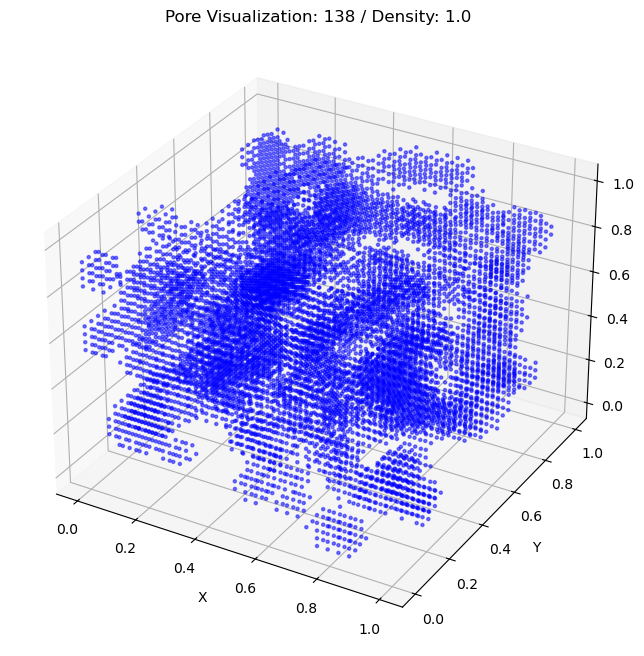

In [3]:
index = "138"
data_to_plot = data_dict[index]

# Extract only the points inside pores (occupancy == 1)
pores = data_to_plot[data_to_plot[:, 3] == 1]

# Extract x, y, z coordinates
x, y, z = pores[:, 0], pores[:, 1], pores[:, 2]

# Plot 3D scatter of pores
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='blue', marker='o', alpha=0.5, s=5)  # Blue dots for pores

# Labels and title
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title(f"Pore Visualization: {index} / Density: {densities_dict[index]}")

# Show the plot
plt.show()

In [ ]:
# Grid with close densities
# Do grid with close densities have similar pore patterns?
close_d = []
for keys, item in densities_dict.items():
    if 0.5<item<0.6:
        close_d.append(keys)

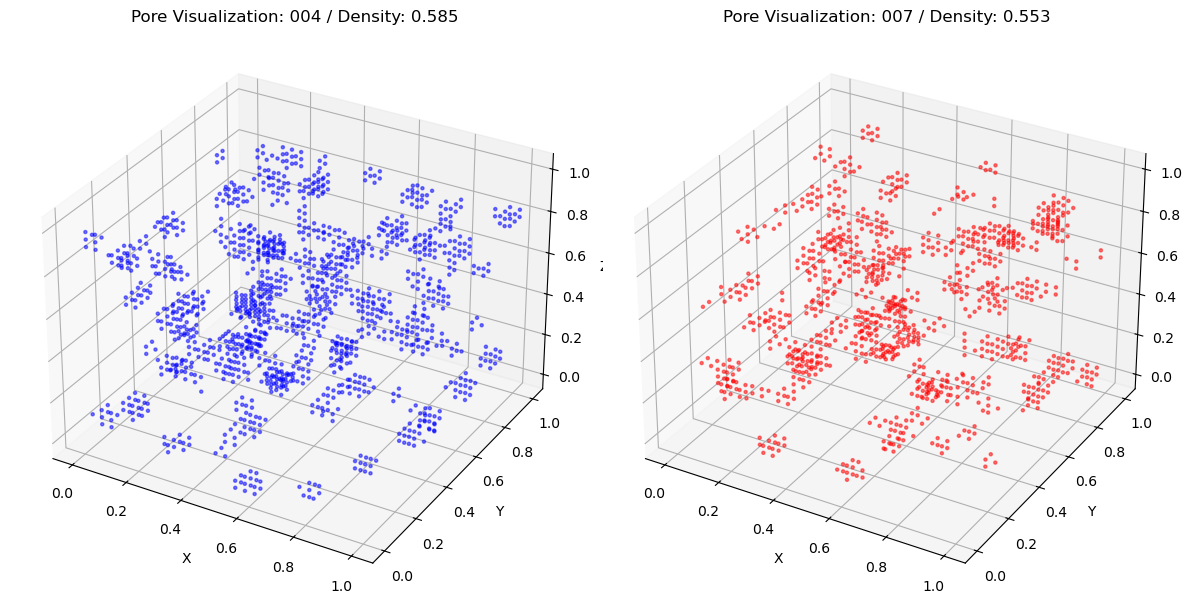

In [ ]:
index1 = close_d[0]
index2 = close_d[1]

data1 = data_dict[index1]
data2 = data_dict[index2]

pores1 = data1[data1[:, 3] == 1]
pores2 = data2[data2[:, 3] == 1]

x1, y1, z1 = pores1[:, 0], pores1[:, 1], pores1[:, 2]
x2, y2, z2 = pores2[:, 0], pores2[:, 1], pores2[:, 2]

fig, axes = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': '3d'})

axes[0].scatter(x1, y1, z1, c='blue', marker='o', alpha=0.5, s=5)
axes[0].set_title(f"Pore Visualization: {index1} / Density: {densities_dict[index1]}")
axes[0].set_xlabel("X")
axes[0].set_ylabel("Y")
axes[0].set_zlabel("Z")

axes[1].scatter(x2, y2, z2, c='red', marker='o', alpha=0.5, s=5)
axes[1].set_title(f"Pore Visualization: {index2} / Density: {densities_dict[index2]}")
axes[1].set_xlabel("X")
axes[1].set_ylabel("Y")
axes[1].set_zlabel("Z")

plt.tight_layout()
plt.show()

****
# Distribution of densities
****

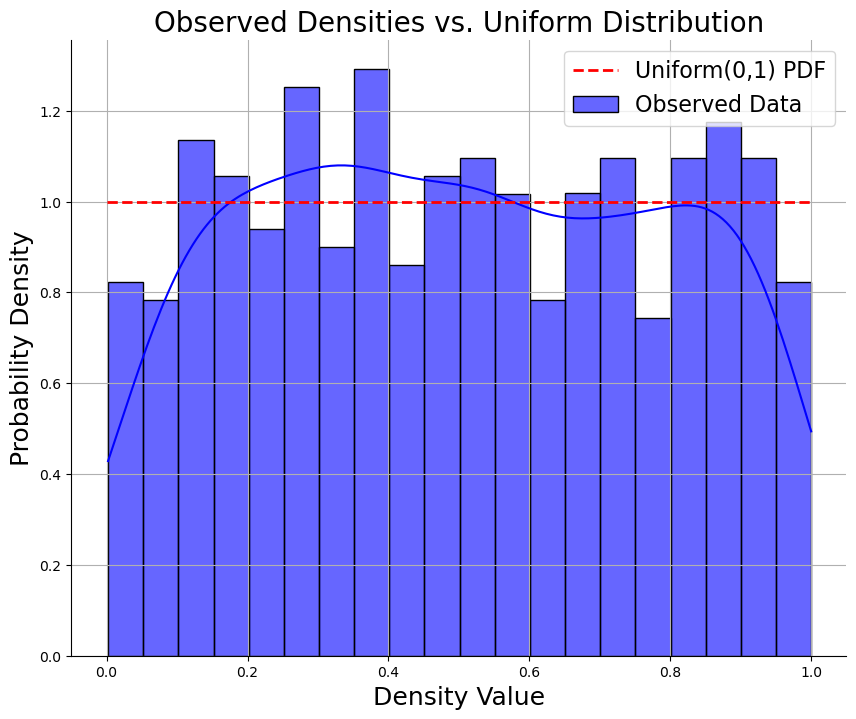

In [20]:
density_values = np.array(list(densities_dict.values()))

# Generate the ideal uniform distribution PDF
x_range = np.linspace(0, 1, 100)
uniform_pdf = uniform.pdf(x_range, loc=0, scale=1)

# histogram of density values
plt.figure(figsize=(10, 8))
sns.histplot(density_values, bins=20, kde=True, stat="density", label="Observed Data", color="blue", alpha=0.6)

# uniform distribution
plt.plot(x_range, uniform_pdf, color="red", linestyle="dashed", linewidth=2, label="Uniform(0,1) PDF")


plt.xlabel("Density Value", fontsize = 18)
plt.ylabel("Probability Density", fontsize = 18)
plt.title("Observed Densities vs. Uniform Distribution", fontsize = 20)
plt.legend(fontsize = 16)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.grid(True)
plt.show()

In [ ]:
# Perform KS test to verify if the distribution of densities is uniform
ks_stat, p_value = ks_1samp(density_values, uniform(loc=0, scale=1).cdf)
print(f"P-value: {p_value:.4f}")

if p_value > 0.05:
    print("The data does not significantly differ from a uniform distribution (Fail to reject H0).")
else:
    print("The data significantly differs from a uniform distribution (Reject H0).")


P-value: 0.8784
The data does not significantly differ from a uniform distribution (Fail to reject H0).


****
# Mapping the density factor to the number of ones in the grid
****

Fitted Power-Law Function: (Density) = 0.0882 * (Number of Ones)^0.2632


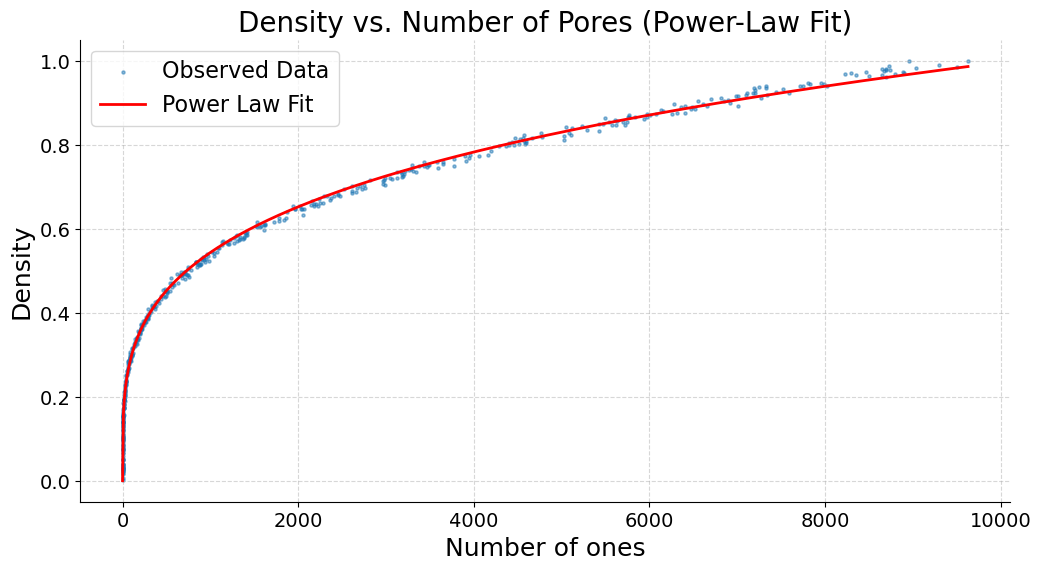

In [ ]:
ones = []
for _, values in grid_dict.items():
    ones.append(values.sum())
ones = np.array(ones)
density_values = np.array(density_values)

# Define a power-law function
def power_law(x, a, b):
    return a * x**b

# Fit the model using curve_fit
params, covariance = curve_fit(power_law, ones, density_values, maxfev=10000)
a_opt, b_opt = params
print(f"Fitted Power-Law Function: (Density) = {a_opt:.4f} * (Number of Ones)^{b_opt:.4f}")

# Generate fitted values
x_range = np.linspace(min(ones), max(ones), 1000)
y_fit = power_law(x_range, a_opt, b_opt)

# Plot Data
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(ones, density_values, marker='o', alpha=0.5, s=5, label="Observed Data")
ax.plot(x_range, y_fit, color="red", linewidth=2, label="Power Law Fit")

# Labels and Grid
ax.set_xlabel("Number of ones", fontsize=18)
ax.set_ylabel("Density", fontsize=18)
ax.set_title("Density vs. Number of Pores (Power-Law Fit)", fontsize=20)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.grid(True, linestyle="--", alpha=0.5)
ax.legend(fontsize = 16)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Show plot
plt.show()

In [14]:
from sklearn.metrics import r2_score
y_pred = power_law(ones, a_opt, b_opt)
r2 = r2_score(density_values, y_pred)
print(f"R² Score: {r2:.4f}")

R² Score: 0.9963
